# Instalação de bibliotecas no ambiente do Sage Maker

In [1]:
!pip install -U pip
!pip install sagemaker==2.15.3
!pip install boto3==1.16.2
!pip install pandas==1.0.1
!pip install numpy==1.18.1
!pip install matplotlib==3.3.3
!pip install scikit-learn==0.24.0

# Preparação de variáveis para o treinamento 

In [2]:
# Importação da biblioteca do Boto3 e 
# criação de sessão para acesso aos recursos
import boto3

In [3]:
sessao_boto = boto3.Session(region_name='us-east-1')

In [4]:
# Função para pegar a "ROLE" (papel) de execução 
# IAM dos recursos no Sage Maker 
from sagemaker import get_execution_role

In [5]:
ROLE = get_execution_role()

In [6]:
print(ROLE)

arn:aws:iam::962752222089:role/service-role/AWSGlueServiceSageMakerNotebookRole-gdelt


In [7]:
# Importação do Sage Maker SDK e criação 
# da sessão do Sage Maker SDK
import sagemaker

In [8]:
sessao_sagemaker = sagemaker.Session(boto_session=sessao_boto)

In [9]:
BUCKET ='sagemaker-alura-engenharia-machine-learning'

PREFIXO_DADOS = 'dados'

PREFIXO_MODELOS = 'modelos'

REGIAO = sessao_sagemaker.boto_region_name

SEMENTE = 42

In [10]:
import sys

sys.path.append("./")

import os
import io
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from time import strftime, gmtime

# Carga de dados no S3 e Training Inputs

In [11]:
# Vamos colocar os caminhos em um dicionario
# apenas para manter a simplicidade e a consistencia
# dos caminhos. Em caso de mudança, essa será refletida
# em todos os caminhos.

dict_caminho_dados = {
    "treino": "dados/df_bytebank_treino.csv",
    "teste": "dados/df_bytebank_teste.csv",
    "validacao": "dados/df_bytebank_validacao.csv",    
}

In [12]:
# Função para upload dos dados no S3
# para as bases de treinamento, 
# teste e validação
bytebank_treino_caminho = \
    sessao_sagemaker.upload_data(path=dict_caminho_dados['treino'],
                                 bucket=BUCKET,
                                 key_prefix=f'{PREFIXO_DADOS}/treino'
                                )

In [13]:
# Upload dos dados de treinamento
bytebank_teste_caminho = \
    sessao_sagemaker.upload_data(path=dict_caminho_dados['teste'],
                                 bucket=BUCKET,
                                 key_prefix=f'{PREFIXO_DADOS}/teste'
                                )

In [14]:
# Upload dos dados de validação
bytebank_validacao_caminho = \
    sessao_sagemaker.upload_data(path=dict_caminho_dados['validacao'],
                                 bucket=BUCKET,
                                 key_prefix=f'{PREFIXO_DADOS}/validacao'
                                )

In [15]:
print(bytebank_treino_caminho)

s3://sagemaker-alura-engenharia-machine-learning/dados/treino/df_bytebank_treino.csv


In [16]:
print(bytebank_teste_caminho)

s3://sagemaker-alura-engenharia-machine-learning/dados/teste/df_bytebank_teste.csv


In [17]:
print(bytebank_validacao_caminho)

s3://sagemaker-alura-engenharia-machine-learning/dados/validacao/df_bytebank_validacao.csv


In [18]:
# Função para criar os canais de 
# treinamento que vamos passar para o estimador
s3_input_treino =\
    sagemaker.TrainingInput(s3_data=bytebank_treino_caminho,
                            content_type='csv')

In [19]:
# Canal de teste
s3_input_teste =\
    sagemaker.TrainingInput(s3_data=bytebank_teste_caminho,
                            content_type='csv')

In [20]:
# Canal de validação
s3_input_validacao =\
    sagemaker.TrainingInput(s3_data=bytebank_validacao_caminho,
                            content_type='csv')

In [21]:
print(s3_input_treino)

# Imagens pré-construídas do Sage Maker

In [22]:
# Imagem do XGBoost que vamos usar no container
from sagemaker import image_uris

In [23]:
container = \
    image_uris.retrieve(
    framework='xgboost',
    region=REGIAO,
    version='0.90-2'
)

In [24]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

# Estimador e construção do modelo

In [25]:
# Criação do estimador
from sagemaker import estimator

In [26]:
estimador_modelo_xgb = \
    estimator.Estimator(
    image_uri=container,
    role=ROLE,
    instance_count=1,
    instance_type='ml.m4.xlarge',
    output_path=f's3://{BUCKET}/{PREFIXO_MODELOS}',
    base_job_name='bytebankPythonSDK',
    sagemaker_session=sessao_sagemaker)

In [27]:
estimador_modelo_xgb

# Hiperparâmetros do modelo

In [28]:
# Definição dos hiperparametros
estimador_modelo_xgb.set_hyperparameters(
    max_depth=5,
    eta=0.3,
    eval_metric='error',
    seed=SEMENTE,
    num_round=100,
    objective='binary:hinge'
)

# Treinamento do modelo 

In [29]:
# Ajuste do modelo
estimador_modelo_xgb.fit({
    'train': s3_input_treino,
    'validation': s3_input_validacao
})

2021-02-15 21:43:57 Starting - Starting the training job...
2021-02-15 21:43:59 Starting - Launching requested ML instances.........
2021-02-15 21:45:31 Starting - Preparing the instances for training......
2021-02-15 21:46:32 Downloading - Downloading input data...
2021-02-15 21:47:06 Training - Downloading the training image..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter eval_metric value error to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:hinge to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[21:47:36] 32849x23 matrix with 75552

Training seconds: 78
Billable seconds: 78


In [30]:
print(ROLE)

arn:aws:iam::962752222089:role/service-role/AWSGlueServiceSageMakerNotebookRole-gdelt


In [31]:
container

'683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-2-cpu-py3'

In [32]:
SEMENTE

42

# Deploy do modelo no endpoint

In [33]:
# Importação do serializador CSV e a 
# definição do objeto de serialização
from sagemaker.serializers import CSVSerializer

In [34]:
serializer = CSVSerializer()

In [35]:
serializer

In [36]:
# Deploy do estimador no endpoint
modelo_endpoint = \
    estimador_modelo_xgb.deploy(
        initial_instance_count=1,
        instance_type='ml.t2.medium',
        endpoint_name='bytebankSDKEndpoint',
        serializer=serializer,
        model_name='bytebankPythonSDK-2021-02-15-21-43-56-913'
)

-----------------!

# Chamada do modelo no endpoint

In [37]:
sessao_sagemaker.download_data(
    path=PREFIXO_DADOS,
    bucket=BUCKET,
    key_prefix=f'{PREFIXO_DADOS}/teste' 
)

In [38]:
df_bytebank_teste \
    = pd.read_csv(dict_caminho_dados['teste'])
df_bytebank_teste.head(5)

,INADIMPLENTE,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,...,SALDO_PAGO_PARCELA_3,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6
0,0,480000,2,2,1,35,0,0,0,0,...,244961,248394,253596,211055,51000,10000,8000,8200,23000,8000
1,1,60000,1,1,2,35,0,1,1,-1,...,-2743,436,20,-225,0,0,5439,0,170,0
2,0,200000,2,3,2,49,-1,-1,0,0,...,27974,30596,38109,22170,20071,20036,15022,15113,22235,3919
3,0,180000,1,1,1,48,0,0,0,0,...,160707,162477,166861,171083,8000,8000,6000,7000,7000,7000
4,1,200000,1,1,1,27,0,0,1,0,...,201605,179983,185993,192317,21364,1401,9637,9559,9497,15555


In [39]:
y_teste = np.array(df_bytebank_teste['INADIMPLENTE'])

In [40]:
del df_bytebank_teste['INADIMPLENTE']

In [41]:
df_bytebank_teste.head(3)

,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,ATRASO_PARCELA_M_5,...,SALDO_PAGO_PARCELA_3,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6
0,480000,2,2,1,35,0,0,0,0,0,...,244961,248394,253596,211055,51000,10000,8000,8200,23000,8000
1,60000,1,1,2,35,0,1,1,-1,0,...,-2743,436,20,-225,0,0,5439,0,170,0
2,200000,2,3,2,49,-1,-1,0,0,0,...,27974,30596,38109,22170,20071,20036,15022,15113,22235,3919


In [42]:
colunas = [
    'CREDITO_CONCEDIDO',
    'GENERO',
    'ESCOLARIDADE',
    'ESTADO_CIVIL',
    'IDADE',
    'ATRASO_PARCELA_M_0',
    'ATRASO_PARCELA_M_2',
    'ATRASO_PARCELA_M_3',
    'ATRASO_PARCELA_M_4',
    'ATRASO_PARCELA_M_5',
    'ATRASO_PARCELA_M_6',
    'SALDO_PAGO_PARCELA_1',
    'SALDO_PAGO_PARCELA_2',
    'SALDO_PAGO_PARCELA_3',
    'SALDO_PAGO_PARCELA_4',
    'SALDO_PAGO_PARCELA_5',
    'SALDO_PAGO_PARCELA_6',
    'VALOR_PAGAMENTO_ANTERIOR_1',
    'VALOR_PAGAMENTO_ANTERIOR_2',
    'VALOR_PAGAMENTO_ANTERIOR_3',
    'VALOR_PAGAMENTO_ANTERIOR_4',
    'VALOR_PAGAMENTO_ANTERIOR_5',
    'VALOR_PAGAMENTO_ANTERIOR_6',
]

df_bytebank_teste['payload'] \
    = df_bytebank_teste[colunas].apply(
        lambda row: ','.join(
            row.values.astype(str)), axis=1)

In [43]:
df_bytebank_teste.head(5)

,CREDITO_CONCEDIDO,GENERO,ESCOLARIDADE,ESTADO_CIVIL,IDADE,ATRASO_PARCELA_M_0,ATRASO_PARCELA_M_2,ATRASO_PARCELA_M_3,ATRASO_PARCELA_M_4,ATRASO_PARCELA_M_5,...,SALDO_PAGO_PARCELA_4,SALDO_PAGO_PARCELA_5,SALDO_PAGO_PARCELA_6,VALOR_PAGAMENTO_ANTERIOR_1,VALOR_PAGAMENTO_ANTERIOR_2,VALOR_PAGAMENTO_ANTERIOR_3,VALOR_PAGAMENTO_ANTERIOR_4,VALOR_PAGAMENTO_ANTERIOR_5,VALOR_PAGAMENTO_ANTERIOR_6,payload
0,480000,2,2,1,35,0,0,0,0,0,...,248394,253596,211055,51000,10000,8000,8200,23000,8000,"480000,2,2,1,35,0,0,0,0,0,0,227221,243942,2449..."
1,60000,1,1,2,35,0,1,1,-1,0,...,436,20,-225,0,0,5439,0,170,0,"60000,1,1,2,35,0,1,1,-1,0,-1,737,320,-2743,436..."
2,200000,2,3,2,49,-1,-1,0,0,0,...,30596,38109,22170,20071,20036,15022,15113,22235,3919,"200000,2,3,2,49,-1,-1,0,0,0,-1,7697,18951,2797..."
3,180000,1,1,1,48,0,0,0,0,0,...,162477,166861,171083,8000,8000,6000,7000,7000,7000,"180000,1,1,1,48,0,0,0,0,0,0,163461,167140,1607..."
4,200000,1,1,1,27,0,0,1,0,0,...,179983,185993,192317,21364,1401,9637,9559,9497,15555,"200000,1,1,1,27,0,0,1,0,0,0,188361,205761,2016..."


In [44]:
# Interação na base de teste e acesso ao 
# via chamadas no endpoint
y_pred = []

for index, row in df_bytebank_teste.iterrows():
    body = row.payload
    predicao = modelo_endpoint.predict(body).decode('utf-8')
    y_pred.append(predicao)

In [45]:
# Apenas alguns rótulos para geração dos gráficos
rotulos_classes = ['adimplente', 'inadimplente']

In [46]:
# Vamos considerar como y sendo a nossa base de validação e
# y_pred como resultado dos dados previstos pelo modelo
y = np.array(y_teste)

In [47]:
y_pred = np.array(y_pred)

In [48]:
y_pred = y_pred.astype(float).astype(int)

In [49]:
y_pred

array([0, 1, 0, ..., 0, 0, 0])

# Relatório de Classificação

In [50]:
pd.DataFrame(
    classification_report(
        y,
        y_pred,
        target_names=rotulos_classes,
        output_dict=True))

,adimplente,inadimplente,accuracy,macro avg,weighted avg
precision,0.785616,0.817541,0.800726,0.801578,0.801574
recall,0.827336,0.774100,0.800726,0.800718,0.800726
f1-score,0.805936,0.795227,0.800726,0.800582,0.800583
support,3446.000000,3444.000000,0.800726,6890.000000,6890.000000


# Métricas de Classificação

In [51]:
def metricas_classificacao(y_test,
                               y_pred,
                               class_labels=rotulos_classes):
    accuracy = accuracy_score(y_test , y_pred)
    print(f"Acurácia: {round(accuracy, 2)* 100} %")

In [52]:
metricas_classificacao(y, y_pred)

Acurácia: 80.0 %


# Matriz de Confusão

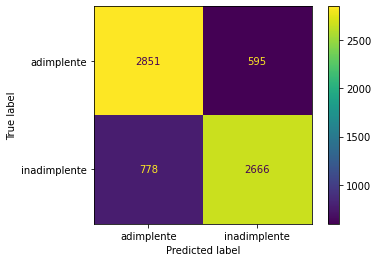

In [53]:
cm = confusion_matrix(y,
                      y_pred)

cm_display = \
    ConfusionMatrixDisplay(cm,
                           display_labels=rotulos_classes).plot(values_format = '.0f')

# Script para fazer a chamada no endpoint

In [54]:
import boto3

endpoint_name = 'bytebankSDKEndpoint'

# Criação do cliente da sessão do boto3
# para runtime
runtime = \
    boto3.Session().client(
        service_name='sagemaker-runtime',
        region_name='us-east-1'
)

payload \
    = '140000,2,2,1,37,0,0,0,0,0,0,58081,51013,54343,27537,9751,12569,5000,5000,5000,3000,3000,5000'

# Criação do objeto que vai pegar a 
# resposta da chamada no Endpoint
response = \
    runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        ContentType='text/csv',
        Body=payload
)

In [55]:
print(response)

{'ResponseMetadata': {'RequestId': '43705328-2386-42e6-91f0-d301c16b1796', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '43705328-2386-42e6-91f0-d301c16b1796', 'x-amzn-invoked-production-variant': 'AllTraffic', 'date': 'Mon, 15 Feb 2021 22:02:04 GMT', 'content-type': 'text/csv; charset=utf-8', 'content-length': '3'}, 'RetryAttempts': 0}, 'ContentType': 'text/csv; charset=utf-8', 'InvokedProductionVariant': 'AllTraffic', 'Body': <botocore.response.StreamingBody object at 0x7f68881f3cf8>}


In [56]:
predicao = int(float((response['Body'].read().decode('UTF-8'))))
print(f'Crédito será inadimplente?: {predicao}')

Crédito será inadimplente?: 0


# Remoção dos artefatos construídos

In [57]:
modelo_endpoint.endpoint_name

'bytebankSDKEndpoint'

In [58]:
# Remoção das configurações do Endpoint
sessao_sagemaker.delete_endpoint_config('bytebankSDKEndpoint')

In [60]:
# Remoção do modelo 
sessao_sagemaker.delete_model('bytebankPythonSDK-2021-02-15-21-43-56-913')

In [61]:
# Remoção do endpoint
sessao_sagemaker.delete_endpoint('bytebankSDKEndpoint')